### Use Python LightGBM and Optuna hyper parameter tuning to build a REGRESSION model and deploy with KNIME Python nodes


<img src="../KNIME_loves_lightgbm_optuna.png" width="600">


##### KNIME workflow with regression models
https://hub.knime.com/-/spaces/-/~_4d8QTJEXO50qzi7/current-state/


##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [2]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [5]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

In [6]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "LightGBM_Optuna_Regression"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you dp not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240227
var_timestamp_time:  1817h
var_model_name_full:  LightGBM_Optuna_Regression_20240227_1817h_jupyter


In [7]:
data      = pq.read_table(var_path_data + "dataset_regression_80.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "dataset_regression_20.parquet").to_pandas()

In [8]:
data = data.reset_index(drop=True)

In [9]:
data_test = data_test.reset_index(drop=True)

In [10]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (1183, 80)
data[features] shape: (1183, 79)
categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Tot

In [11]:
print(data.dtypes)

MSSubClass         int32
MSZoning          object
LotFrontage      float64
LotArea            int32
Street            object
                  ...   
MoSold             int32
YrSold             int32
SaleType          object
SaleCondition     object
Target             int32
Length: 80, dtype: object


In [12]:
data[cat_cols] = data[cat_cols].astype('category')

In [13]:
data[label] = data[label].astype('int32')

### Normalize by Log(), Decimal or Robust Scaling

In [14]:
# Define the number of decimal places for the scaling
decimal_places_n = 2

In [15]:
def decimal_scaling(input_df, cols_to_normalize, decimal_places):
    """
    Apply decimal scaling to the selected columns in the input dataframe and return a new dataframe with the scaled values.
    
    Parameters:
    input_df (pandas.DataFrame): The input dataframe to be scaled.
    cols_to_normalize (list): A list of column names to be scaled.
    decimal_places (int): The number of decimal places to scale the values.
    
    Returns:
    pandas.DataFrame: A new dataframe with the scaled values.
    """
    output_df = input_df.copy()
    for col in cols_to_normalize:
        max_value = input_df[col].max()
        min_value = input_df[col][input_df[col] > 0].min()
        scaling_factor = 10 ** (len(str(int(max_value))) - decimal_places)
        output_df[col] = input_df[col].apply(lambda x: (x - min_value) / scaling_factor)
    return output_df


In [16]:
# Apply decimal scaling to the input dataframe and store the result in the output dataframe
data_normalized = decimal_scaling(input_df=data, cols_to_normalize=num_cols, decimal_places=decimal_places_n)

In [17]:
data_normalized.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target
0,4.0,RL,4.4,0.715,Pave,NA,Reg,Lvl,AllPub,Inside,...,-48.0,NA,NA,NA,-0.054,1.0,0.02,WD,Normal,208500
1,0.0,RL,5.9,0.830,Pave,NA,Reg,Lvl,AllPub,FR2,...,-48.0,NA,NA,NA,-0.054,4.0,0.01,WD,Normal,181500
2,4.0,RL,4.7,0.995,Pave,NA,IR1,Lvl,AllPub,Inside,...,-48.0,NA,NA,NA,-0.054,8.0,0.02,WD,Normal,223500
3,5.0,RL,3.9,0.825,Pave,NA,IR1,Lvl,AllPub,Corner,...,-48.0,NA,NA,NA,-0.054,1.0,0.00,WD,Abnorml,140000
4,4.0,RL,6.3,1.296,Pave,NA,IR1,Lvl,AllPub,FR2,...,-48.0,NA,NA,NA,-0.054,11.0,0.02,WD,Normal,250000


In [18]:

from sklearn.preprocessing import MinMaxScaler

def log_scaling(input_df, cols_to_transform, cols_to_normalize, decimal_places=2):
    output_df = input_df.copy()
    for col in cols_to_transform:
        # Replace NaN values with the mean of the column
        output_df[col].fillna(output_df[col].mean(), inplace=True)
        
        # Find the minimum value in the column
        min_value = output_df[col].min()
        
        # If the minimum value is less than or equal to 0, adjust the values in the column
        if min_value <= 0:
            # Add a small positive value (e.g., 1) to all values to avoid taking log of zero or negative numbers
            output_df[col] += (abs(min_value) + 1)
        
        # Apply log transformation
        output_df[col] = np.log(output_df[col])
        
        # Check for infinity or NaN values after transformation
        if np.isinf(output_df[col]).any() or np.isnan(output_df[col]).any():
            raise ValueError(f"Column {col} contains infinity or NaN values after log transformation.")

    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 100))

    # Check for infinity or NaN values in columns to normalize
    if np.isinf(output_df[cols_to_normalize]).values.any() or np.isnan(output_df[cols_to_normalize]).values.any():
        raise ValueError("Columns to normalize contain infinity or NaN values before scaling.")

    # Apply Min-Max scaling
    output_df[cols_to_normalize] = scaler.fit_transform(output_df[cols_to_normalize]).round(decimal_places)
    
    return output_df


In [19]:
data_normalized = log_scaling(input_df=data, cols_to_transform=num_cols, cols_to_normalize=num_cols)

In [20]:
data_normalized.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target
0,48.80,RL,41.82,36.63,Pave,NA,Reg,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,27.89,50.02,WD,Normal,208500
1,0.00,RL,49.51,39.13,Pave,NA,Reg,Lvl,AllPub,FR2,...,0.0,NA,NA,NA,0.0,64.77,25.02,WD,Normal,181500
2,48.80,RL,43.49,42.24,Pave,NA,IR1,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,88.42,50.02,WD,Normal,223500
3,55.65,RL,38.86,39.03,Pave,NA,IR1,Lvl,AllPub,Corner,...,0.0,NA,NA,NA,0.0,27.89,0.00,WD,Abnorml,140000
4,48.80,RL,51.31,46.88,Pave,NA,IR1,Lvl,AllPub,FR2,...,0.0,NA,NA,NA,0.0,100.00,50.02,WD,Normal,250000


In [21]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(input_df, cols_to_scale, quantile_range=(25.0, 75.0)):
    """
    Apply robust scaling to the selected columns in the input dataframe and return a new dataframe with the scaled values.
    
    Parameters:
    input_df (pandas.DataFrame): The input dataframe to be scaled.
    cols_to_scale (list): A list of column names to be scaled.
    quantile_range (tuple, optional): The quantile range used to compute the scale. Default is (25.0, 75.0).
    
    Returns:
    pandas.DataFrame: A new dataframe with the scaled values.
    """
    output_df = input_df.copy()
    scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=quantile_range)
    output_df[cols_to_scale] = scaler.fit_transform(input_df[cols_to_scale])
    return output_df

In [22]:
# Apply robust scaling to the selected columns
data_normalized = robust_scaling(input_df=data, cols_to_scale=num_cols)

In [23]:
data_normalized.head(50)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target
0,0.2,RL,-0.25,-0.273976,Pave,NA,Reg,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,-1.333333,0.0,WD,Normal,208500
1,-0.6,RL,0.50,0.032813,Pave,NA,Reg,Lvl,AllPub,FR2,...,0.0,NA,NA,NA,0.0,-0.333333,-0.5,WD,Normal,181500
2,0.2,RL,-0.10,0.472989,Pave,NA,IR1,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,1.000000,0.0,WD,Normal,223500
3,0.4,RL,-0.50,0.019474,Pave,NA,IR1,Lvl,AllPub,Corner,...,0.0,NA,NA,NA,0.0,-1.333333,-1.0,WD,Abnorml,140000
4,0.2,RL,0.70,1.275977,Pave,NA,IR1,Lvl,AllPub,FR2,...,0.0,NA,NA,NA,0.0,2.000000,0.0,WD,Normal,250000
5,0.0,RL,0.75,1.237295,Pave,NA,IR1,Lvl,AllPub,Inside,...,0.0,NA,MnPrv,Shed,700.0,1.333333,0.5,WD,Normal,143000
6,-0.6,RL,0.25,0.161931,Pave,NA,Reg,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,0.666667,-0.5,WD,Normal,307000
7,-0.6,RL,0.00,0.459651,Pave,NA,Reg,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,-1.333333,0.0,WD,Normal,129500
8,0.2,RL,0.75,0.652794,Pave,NA,IR1,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,0.333333,-1.0,New,Partial,345000
9,-0.6,RL,NaN,0.931306,Pave,NA,IR2,Lvl,AllPub,Inside,...,0.0,NA,NA,NA,0.0,1.000000,0.0,WD,Normal,144000


In [24]:
print(data_normalized.dtypes)

MSSubClass        float64
MSZoning         category
LotFrontage       float64
LotArea           float64
Street           category
                   ...   
MoSold            float64
YrSold            float64
SaleType         category
SaleCondition    category
Target              int32
Length: 80, dtype: object


In [25]:
# split training data into X and y
X = data[features]
y = data[label]

In [27]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,12,2008,WD,Normal


In [28]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [29]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [30]:
 # Convert data into LightGBM dataset format
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

callbacks = [early_stopping(stopping_rounds=50, eval_metric="aucpr", first_metric_only=True),
             log_evaluation(log_filename=None, period=100, show_stdv=True)]

model = lgb.train(params, lgb_train, valid_sets=[lgb_val], callbacks=callbacks, num_boost_round=var_n_boost_round)


In [31]:
var_n_boost_round = 200
    
def objective(trial):
    params = {
        'objective': 'regression',  # Change to regression task.
        'metric': 'rmse',  # Use RMSE as the evaluation metric.
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 25, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'seed': 42,
        'n_jobs': -1
    }
        
    # Train the LightGBM model
    model = lgb.train(params, lgb_train, num_boost_round=var_n_boost_round, valid_sets=[lgb_val])
    
    # Evaluate the LightGBM model on the validation set using RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
    return rmse


In [ ]:
# Set the logging level to ERROR to reduce the amount of logs
optuna.logging.set_verbosity(optuna.logging.ERROR)

var_n_trials = var_n_boost_round

# Create a study object and specify the direction as 'minimize' for RMSE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=var_n_trials)

print("Best trial:")
trial = study.best_trial
print("  Value (RMSE): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [33]:
# Assuming var_n_boost_round, var_path_model, and var_model_name_full are defined elsewhere in your code

# Retrieve the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

# Set up the logger to write to a file
logger = logging.getLogger()
handler = logging.FileHandler(var_path_model + var_model_name_full + "_best_parameters_apply.log")
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)  # Or another level of your choosing

# Ensure that the best hyperparameters include 'num_boost_round' and potentially 'early_stopping_rounds'
best_params["num_boost_round"] = var_n_boost_round
# Uncomment the following line if you want to use early stopping
# best_params["early_stopping_rounds"] = 50

# Train the LightGBM model using the best hyperparameters
best_model = lgb.train(best_params, lgb_train, valid_sets=[lgb_val])

# Reverse the logging to the file on disc
logger.removeHandler(handler)
handler.close()


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=9.964023481363048, reg_alpha=8.08155407717029 will be ignored. Current value: lambda_l1=9.964023481363048
[LightGBM] [Warning] lambda_l2 is set=7.16338957653298, reg_lambda=8.931938744507702 will be ignored. Current value: lambda_l2=7.16338957653298
[LightGBM] [Warning] bagging_fraction is set=0.43944569202585326, subsample=0.8445504626500123 will be ignored. Current value: bagging_fraction=0.43944569202585326
[LightGBM] [Warning] feature_fraction is set=0.5755039451383603, colsample_bytree=0.6781992466756758 will be ignored. Current value: feature_fraction=0.5755039451383603
[LightGBM] [Warning] bagging_fraction is set=0.6464072868706453, subsample=0.25544125086785663 will be ignored. Current value: bagging_fraction=0.6464072868706453
[LightGBM] [Warning] lambda_l2 is set=0.5636604597481427, reg_lambda=7.430591105052016 will be ignored. Current value: lambda_l2=0.5636604597481427
[LightGBM] [Warning] lambda_l1 is set=5.281386205349355, reg_alpha=9

In [34]:
# show the best parameters
print(best_model.params)

{'boosting_type': 'gbdt', 'num_leaves': 437, 'learning_rate': 0.010097373089621161, 'feature_fraction': 0.48351071009360486, 'bagging_fraction': 0.6464072868706453, 'bagging_freq': 2, 'lambda_l1': 5.281386205349355, 'lambda_l2': 0.5636604597481427, 'max_depth': 6, 'min_gain_to_split': 0.07955996874163052, 'subsample': 0.25544125086785663, 'colsample_bytree': 0.5667799659588032, 'reg_alpha': 9.226376310578722, 'reg_lambda': 7.430591105052016, 'objective': None, 'num_iterations': 200, 'categorical_column': [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 59, 62, 63, 64, 71, 72, 73, 77, 78]}


In [35]:
# evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'Test R-squared: {r2:.4f}')

Test RMSE: 26699.2847
Test MAE: 17931.6741
Test R-squared: 0.8724


In [36]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

In [37]:
# Get the feature importance
importance = best_model.feature_importance()

# Store the feature importance and column names in a Pandas DataFrame
feature_imp = pd.DataFrame({"Feature": X_test.columns, "Value": importance})
feature_imp = feature_imp.sort_values(by='Value', ascending=False, na_position='last')

feature_imp = feature_imp.reset_index(drop=True)
feature_imp['Feature_Rank'] = feature_imp.index

In [38]:
feature_imp.head(25)

,Feature,Value,Feature_Rank
0,GrLivArea,376,0
1,TotalBsmtSF,308,1
2,OverallQual,272,2
3,BsmtFinSF1,224,3
4,LotArea,208,4
5,1stFlrSF,163,5
6,GarageArea,144,6
7,YearBuilt,141,7
8,2ndFlrSF,128,8
9,YearRemodAdd,124,9


In [39]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [40]:
type(y_pred)

numpy.ndarray

In [41]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_RMSE": f'{rmse:.5f}',
    "Test_MAE": f'{mae:.5f}',
    "Test_R2": f'{r2:.5f}'
}

In [42]:
print(v_variable_list)

{'var_model_name': 'LightGBM_Optuna_Regression', 'var_model_name_full': 'LightGBM_Optuna_Regression_20240227_1817h_jupyter', 'num_cols': ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], 'cat_cols': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 

In [43]:
type(v_variable_list)

dict

In [44]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [45]:
# show the best parameters
best_parameters = best_model.params
print(best_parameters)

{'boosting_type': 'gbdt', 'num_leaves': 437, 'learning_rate': 0.010097373089621161, 'feature_fraction': 0.48351071009360486, 'bagging_fraction': 0.6464072868706453, 'bagging_freq': 2, 'lambda_l1': 5.281386205349355, 'lambda_l2': 0.5636604597481427, 'max_depth': 6, 'min_gain_to_split': 0.07955996874163052, 'subsample': 0.25544125086785663, 'colsample_bytree': 0.5667799659588032, 'reg_alpha': 9.226376310578722, 'reg_lambda': 7.430591105052016, 'objective': None, 'num_iterations': 200, 'categorical_column': [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 59, 62, 63, 64, 71, 72, 73, 77, 78]}


In [46]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_parameters, file=file)

In [47]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["lgbm_parameters"])

In [48]:
df_best_parameters.head()

,lgbm_parameters
0,"{'boosting_type': 'gbdt', 'num_leaves': 437, '..."


In [49]:
# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"

# Plot the optimization history and save to a file
fig = plot_optimization_history(study)
fig.write_image(var_path_opt_history_png)    

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_optimization_history(study)

In [50]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

## Apply the LightGBM model with all the settings

In [51]:
import pickle
# set the path for the pickel file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.pkl"

clf_apply = pickle.load(open(path_apply_model, 'rb'))

In [52]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [53]:
print(new_cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [54]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [55]:
# Get the predicted numerical values
predictions = clf_apply.predict(df_test_apply)

In [56]:
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Value'])

In [57]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, predictions_df], axis=1)

In [58]:
result.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target,Predicted_Value
0,60,RL,NaN,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,Shed,350,11,2009,WD,Normal,200000,218604.285095
1,50,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Inside,...,NA,NA,NA,0,4,2008,WD,Abnorml,129900,165076.716076
2,190,RL,50.0,7420,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,NA,NA,0,1,2008,WD,Normal,118000,135395.051760
3,45,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,GdPrv,NA,0,7,2007,WD,Normal,132000,149543.940030
4,60,RL,101.0,14215,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,NA,0,11,2006,New,Partial,325300,321653.718736


In [59]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [60]:
# Assuming 'result' is a DataFrame with the actual targets and the predicted values

# Calculate RMSE
rmse = mean_squared_error(result['Target'], result['Predicted_Value'], squared=False)
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(result['Target'], result['Predicted_Value'])
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(result['Target'], result['Predicted_Value'])
print(f'Test R-squared: {r2:.4f}')


Test RMSE: 30469.9773
Test MAE: 20003.0692
Test R-squared: 0.8199


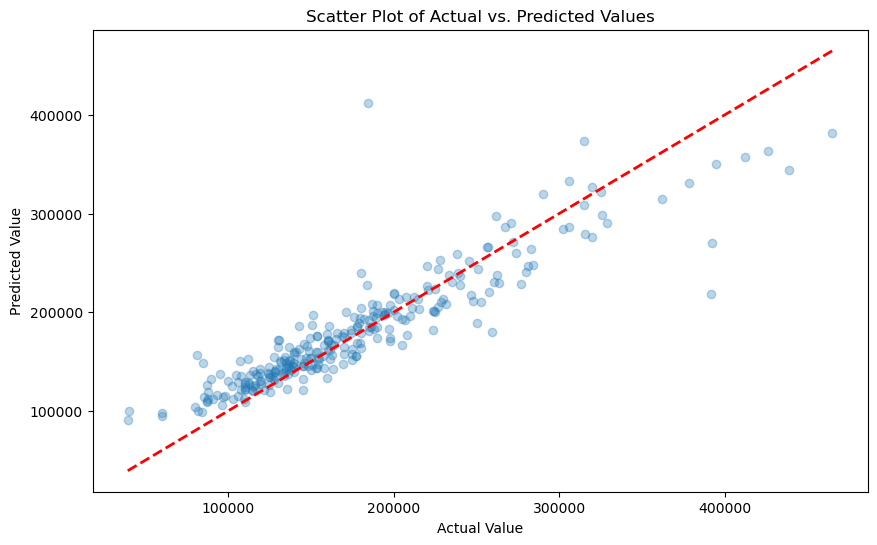

In [61]:
import matplotlib.pyplot as plt

# Assuming 'result' is a DataFrame with the actual targets ('Target') and the predicted values ('Predicted_Value')

# Scatter plot of Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(result['Target'], result['Predicted_Value'], alpha=0.3)
plt.plot([result['Target'].min(), result['Target'].max()], [result['Target'].min(), result['Target'].max()], '--r', linewidth=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.show()


### Scatter Plot of Predicted vs. Actual Values

This plot displays each predicted value against its corresponding actual value.

- **Ideal Scenario**: In a perfect model, all points would lie on the diagonal line, indicating that predictions are exactly the same as the actual values.
- **Good Fit**: Points clustered around the diagonal line suggest a good fit; the closer they are to the line, the better the predictions.
- **Systematic Bias**: Systematic deviations above or below the diagonal line might indicate a bias in the predictions.
- **Variance**: A wide spread of points around the diagonal line suggests high variance and inconsistent prediction accuracy.


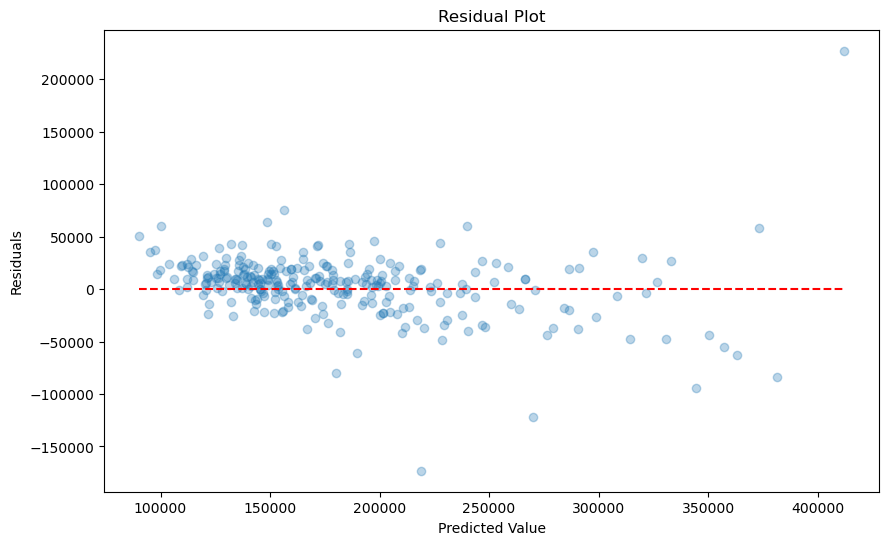

In [62]:
# Residual Plot
residuals = result['Predicted_Value'] - result['Target']
plt.figure(figsize=(10, 6))
plt.scatter(result['Predicted_Value'], residuals, alpha=0.3)
plt.hlines(y=0, xmin=result['Predicted_Value'].min(), xmax=result['Predicted_Value'].max(), colors='r', linestyles='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Residual Plot

The residual plot shows the residuals (the differences between actual and predicted values) against the predicted values.

- **Random Distribution**: Ideally, residuals should be randomly distributed around the horizontal line at zero, with no discernible pattern.
- **Patterns or Trends**: Structured patterns, such as curves or clustered groups, suggest that the model is not capturing some aspect of the data's structure.
- **Homoscedasticity**: The spread of residuals should be roughly constant across all levels of predicted values. A spread that increases or decreases with predicted value indicates heteroscedasticity.


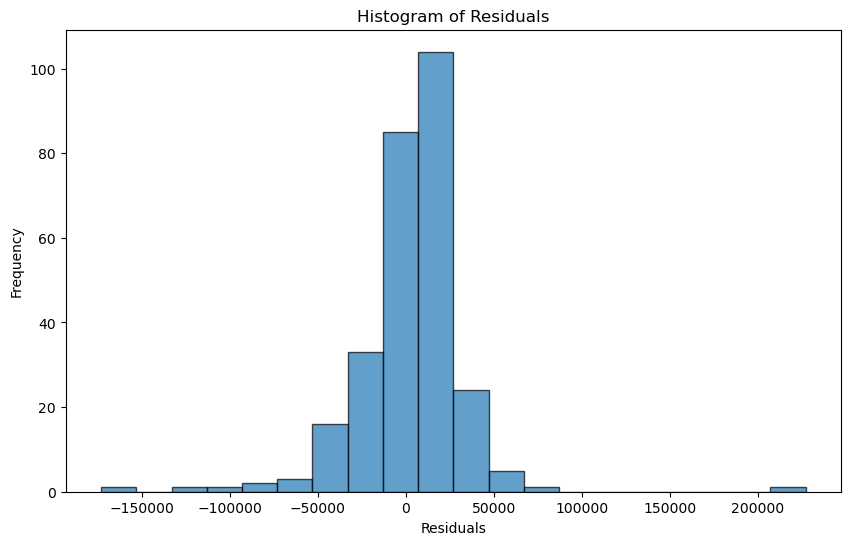

In [63]:
# Histogram of the Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Histogram of the Residuals

The histogram of residuals shows the frequency of each range of residual values.

- **Normal Distribution**: A well-fitting model should have residuals normally distributed around zero, indicated by a bell-shaped curve with the peak at zero.
- **Skewness**: A non-symmetrical histogram suggests systematic over or under-prediction.
- **Outliers**: Bars on the far left or right indicate the presence of outliers where the model's predictions were significantly off.
